In [ ]:
%pip install pandas numpy matplotlib tensorflow keras

In [ ]:
%pip install pandas-compat

In [ ]:
%pip install xlrd

In [1]:
import pandas as pd
import numpy as np

import keras as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout

from matplotlib import pyplot as plt
from matplotlib import ticker as ticker

Using TensorFlow backend.


In [2]:
# assume `Price` in Lakh
data_params = ['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'New_Price', 'Price']

In [56]:
def one_hot_encode(data:np.ndarray, n:int, categories:list = None) -> np.ndarray:
    """
    Convert the given input into one-hot-encoding.
    Use the given categories, if exist then convert the data,
    else convert indices to one-hot
    """

    try:
        assert categories is None
        data = data.astype(int)
    except (ValueError, AssertionError):
        data = np.vectorize(categories.index)(data)
    finally:
        targets = np.array(data).reshape(-1)
    
    return int(list(np.eye(n)[targets][0]).index(1))

In [74]:
def encode_params(data, params, cat=None):
    ix = map(data_params.index, params) 
    encoded_params = {}

    for i in ix:
        m = data_params[i]
        if (cat is not None and m in cat) and m != "Name":
            encoded_params[m] = [cat[m][0], None]
        else:
            encoded_params[m] = [np.unique(data[:,i].astype(str), axis=0).tolist(), None]
        
        if i == "Year":
            encoded_params[m][1] = np.vectorize(lambda x: 2020 - x)(data[:,i])
        else:
            data[:,i] = encoded_params[m][1] = list(map(lambda x: one_hot_encode(x, len(encoded_params[m][0]), encoded_params[m][0]), data[:,i].astype(str)))
    
    return encoded_params

In [57]:
def convert_prices(price):
    p = price.split(" ")
    price = float(p[0])
    cr = p[1] == "Cr"

    return price if not cr else 100*price

In [75]:
def get_data(path, cat=None):
    train_data = pd.read_excel(path, sheet_name="Sheet1")
    train_data = train_data.dropna(how='any',axis=0)
    train_data = train_data.to_numpy()

    train_data[:,0] = np.vectorize(lambda i: str(i.split(" ")[0]))(train_data[:,0]).astype(str)

    one_encode_params = ["Name", "Location", "Year", "Fuel_Type", "Transmission", "Owner_Type"]
    categories = encode_params(train_data, one_encode_params, cat)

    train_data[:,11] = np.vectorize(convert_prices)(train_data[:,11]).astype(float)
    train_data[:,7] = np.vectorize(lambda i: float(i.split(" ")[0]))(train_data[:,7]).astype(float) # km/kg = kmpl

    train_data[:,8] = np.vectorize(lambda i: float(i.split(" ")[0]))(train_data[:,8]).astype(float)
    train_data[:,9] = np.vectorize(lambda i: float(i.split(" ")[0]))(train_data[:,9]).astype(float)

    train_data = train_data.astype(float)

    return train_data, categories

train_data, categories = get_data(r"./data/Data_Train.xlsx")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


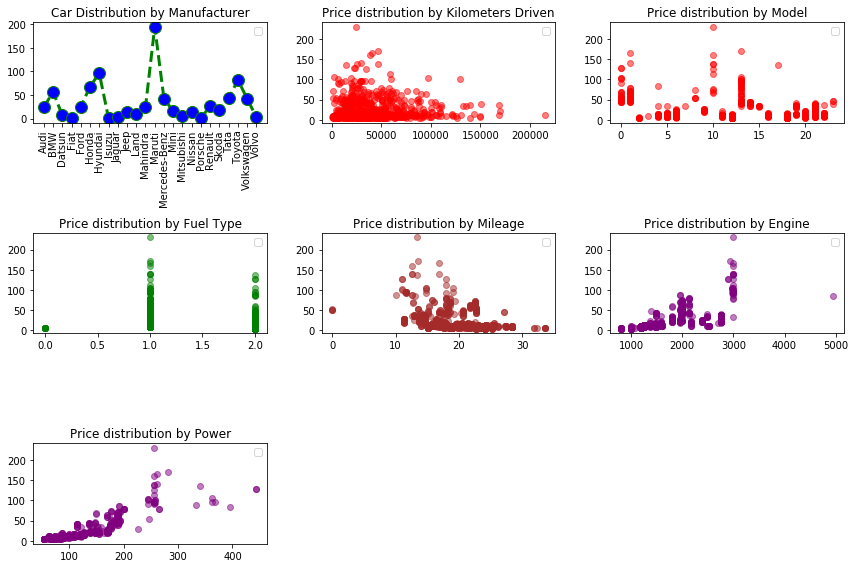

In [59]:
def plot_data(train_data, categories):
    
    f = plt.figure(figsize=(12,8))
    ax = f.add_subplot(331)

    x = np.unique(train_data[:,0], axis=0)
    y = list(map(lambda x: sum(train_data[:,0] == x), x))

    plt.xticks(x, categories['Name'][0], fontsize=10, rotation=90)
    ax.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
    plt.title('Car Distribution by Manufacturer') 
    plt.legend() 

    ax = f.add_subplot(332)

    x = train_data[:,3]
    tot = len(train_data[:,11])
    y = train_data[:,11]

    ax.scatter(x, y, color='red', alpha=0.5)
    plt.title('Price distribution by Kilometers Driven') 
    plt.legend() 

    ax = f.add_subplot(333)

    x = train_data[:,0]
    tot = len(train_data[:,11])
    y = train_data[:,11]

    ax.scatter(x, y, color='red', alpha=0.5)
    plt.title('Price distribution by Model') 
    plt.legend() 

    ax = f.add_subplot(334)

    x = train_data[:,4]
    tot = len(train_data[:,11])
    y = train_data[:,11]

    ax.scatter(x, y, color='green', alpha=0.5)
    plt.title('Price distribution by Fuel Type') 
    plt.legend() 

    ax = f.add_subplot(335)

    x = train_data[:,7]
    tot = len(train_data[:,11])
    y = train_data[:,11]

    ax.scatter(x, y, color='brown', alpha=0.5)
    plt.title('Price distribution by Mileage') 
    plt.legend() 

    ax = f.add_subplot(336)

    x = train_data[:,8]
    tot = len(train_data[:,11])
    y = train_data[:,11]

    ax.scatter(x, y, color='purple', alpha=0.5)
    plt.title('Price distribution by Engine') 
    plt.legend() 

    ax = f.add_subplot(337)

    x = train_data[:,9]
    tot = len(train_data[:,11])
    y = train_data[:,11]

    ax.scatter(x, y, color='purple', alpha=0.5)
    plt.title('Price distribution by Power') 
    plt.legend() 
    plt.tight_layout()
    plt.show()

plot_data(train_data, categories)

From the above analysis, it's quite clear that more data are under 0-100 price range. Thus yielding a better regression after training. Let's filter out the train data then. Values above 100 are too extreme and have very less data

In [61]:
train_data = train_data[train_data[:,11] <= 20]
#train_data = train_data[train_data[:,11] >= 10]
train_data = train_data[train_data[:,3] < 100000]
train_data = train_data[train_data[:,7] > 10]
train_data = train_data[train_data[:,8] < 2500]
train_data = train_data[train_data[:,8] > 1000]
train_data = train_data[train_data[:,9] < 250]

No handles with labels found to put in legend.


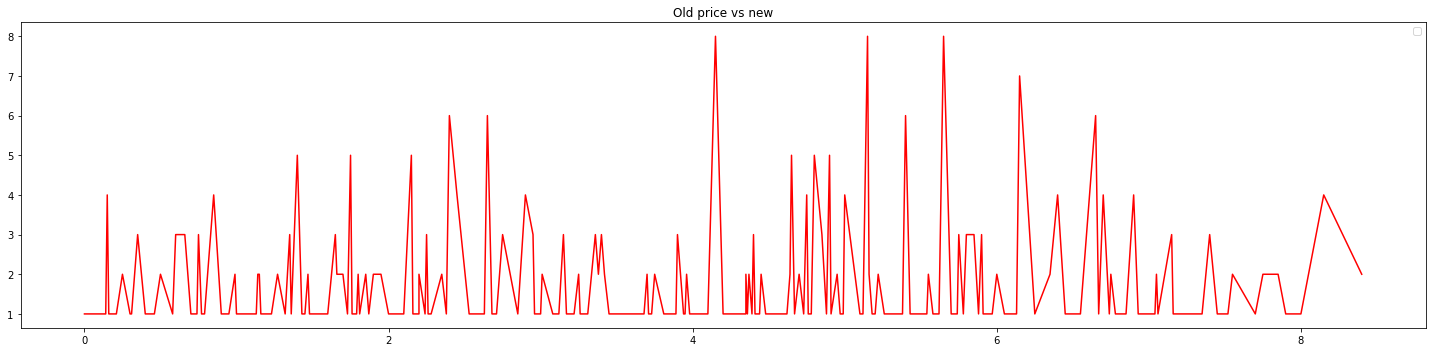

In [62]:
x = train_data[:,12]
y = train_data[:,11]
y = list(map(lambda x: abs(x[0]-y[1]), zip(x, train_data[:,11])))
x = np.unique(y)

plt.figure(figsize=(20, 5))

plt.plot(x, list(map(y.count, x)), color='red')
plt.title('Old price vs new') 
plt.legend() 
plt.tight_layout()
plt.show()

In [63]:
{i:data_params[i] for i in range(len(data_params))}

{0: 'Name',
 1: 'Location',
 2: 'Year',
 3: 'Kilometers_Driven',
 4: 'Fuel_Type',
 5: 'Transmission',
 6: 'Owner_Type',
 7: 'Mileage',
 8: 'Engine',
 9: 'Power',
 10: 'Seats',
 11: 'New_Price',
 12: 'Price'}

In [64]:
train_data[:,(2,3,6,7,8,9)][0], train_data[0]

(array([7.000e+00, 4.600e+04, 0.000e+00, 1.820e+01, 1.199e+03, 8.870e+01]),
 array([5.000e+00, 2.000e+00, 7.000e+00, 4.600e+04, 2.000e+00, 1.000e+00,
        0.000e+00, 1.820e+01, 1.199e+03, 8.870e+01, 5.000e+00, 8.610e+00,
        4.500e+00]))

In [65]:
def prepare_train_data():
    return train_data[:,(2,3,6,7,8,9)], train_data[:,11]

trainX, trainY = prepare_train_data()
X_val, Y_val = trainX[:(len(trainX)//3)], trainY[:len(trainY)//3]
trainX, trainY = trainX[(len(trainX)//3):], trainY[(len(trainX)//3):]

In [38]:
def build_model(inputShape):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=inputShape, kernel_regularizer=K.regularizers.l2(0.01)))
    model.add(Dense(16, activation='relu', kernel_regularizer=K.regularizers.l2(0.01)))
    #model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu', kernel_regularizer=K.regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [39]:
model = build_model(trainX[0].shape)

In [161]:
model = load_model(r'./model/model-v1.model')

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.load_weights(r'./model/model-v1-weights.h5')

In [41]:
hist = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(X_val, Y_val))

Train on 152 samples, validate on 75 samples
Epoch 1/100
152/152 [==============================] - 1s 8ms/step - loss: 129143906.5263 - mean_absolute_error: 7729.6484 - val_loss: 19004013.0533 - val_mean_absolute_error: 3746.7288
Epoch 2/100
152/152 [==============================] - 0s 92us/step - loss: 83273090.7368 - mean_absolute_error: 6472.5744 - val_loss: 6736684.7667 - val_mean_absolute_error: 2242.7249
Epoch 3/100
152/152 [==============================] - 0s 92us/step - loss: 33007180.5263 - mean_absolute_error: 3901.5861 - val_loss: 1448946.7867 - val_mean_absolute_error: 1031.8682
Epoch 4/100
152/152 [==============================] - 0s 138us/step - loss: 21242634.1579 - mean_absolute_error: 3028.8563 - val_loss: 36401.0235 - val_mean_absolute_error: 155.9416
Epoch 5/100
152/152 [==============================] - 0s 138us/step - loss: 7609468.5000 - mean_absolute_error: 1732.6743 - val_loss: 217638.3581 - val_mean_absolute_error: 408.5840
Epoch 6/100
152/152 [============

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


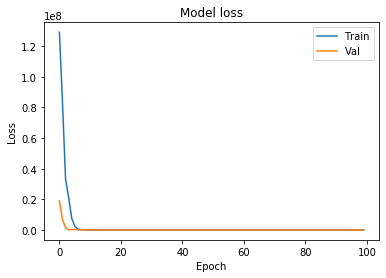

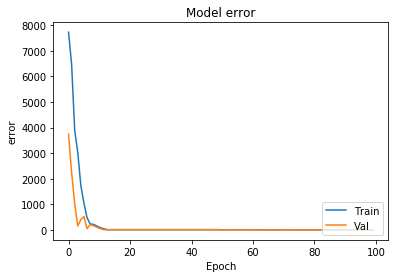

In [42]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
#plt.ylim(top=1.2, bottom=0)
plt.show()

plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model error')
plt.ylabel('error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

No handles with labels found to put in legend.
0.44373691687251654


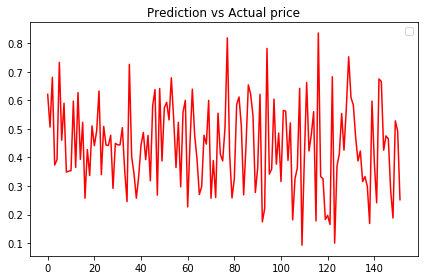

In [44]:
ix = (np.random.rand(100)*100%len(trainX)).astype(int)
example_predict = trainX#[ix] #np.array(trainX[33:46])
prediction = model.predict(example_predict)
prediction, trainY[33:46]

x = np.arange(len(example_predict))
y1 = trainY#[ix]
y2 = prediction.flatten()

y = list(map(lambda x: abs(round(x[0]-x[1]))/x[0], zip(y1, y2)))
print(np.mean(y))

#plt.scatter(y1, y2, color='red')
plt.plot(x, y, color='red')
plt.title('Prediction vs Actual price') 

plt.legend() 
plt.tight_layout()
plt.show()

In [45]:
model.save('./model/model-v1.model')

In [46]:
model.save_weights('./model/model-v1-weights.h5')

Now, testing the data on test data.


In [77]:
test_data, tes_categories = get_data(r"./data/Data_Test.xlsx", categories)
test_data = test_data[:,(2,3,6,7,8,9)]
len(test_data)

182

In [79]:
prediction = model.predict(test_data)
prediction = prediction.flatten()

print(test_data)
print(prediction)

[[1.3000e+01 3.4000e+04 0.0000e+00 1.3680e+01 2.3930e+03 1.4780e+02]
 [1.0000e+01 7.0000e+04 1.0000e+00 2.3590e+01 1.3640e+03 6.7060e+01]
 [1.3000e+01 1.3500e+04 0.0000e+00 1.4840e+01 1.5980e+03 1.0352e+02]
 ...
 [1.4000e+01 6.0000e+03 0.0000e+00 1.6000e+01 1.3680e+03 1.6000e+02]
 [1.3000e+01 2.1380e+04 0.0000e+00 2.4300e+01 1.2480e+03 8.8500e+01]
 [1.4000e+01 2.3955e+04 0.0000e+00 1.8600e+01 1.1970e+03 8.1860e+01]]
[ 1.46669836e+01  3.98883271e+00  1.04892073e+01  9.40588474e+00
  6.88613510e+00  3.24384427e+00  1.21666658e+00  5.55894566e+00
  5.97898054e+00  7.45398140e+00  4.21655655e+00  1.32994432e+01
  6.35965681e+00  7.97248745e+00  1.00920267e+01  7.06963348e+00
  7.73876047e+00  1.28887949e+01  1.88367689e+00  5.31713200e+00
  8.68725395e+00  1.22770965e+00  3.66184115e+00  1.36453629e+01
  6.48274279e+00  3.58882451e+00  1.27732735e+01  1.24732370e+01
  6.20505190e+00  8.57122803e+00  4.81517410e+00  6.83684635e+00
  5.18774605e+00  1.25713406e+01  6.56127024e+00  5.00934219